In [52]:
import pandas as pd
import requests 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pyfile.scrapestockdata import data_tsla, Trade_Buy, Trade_Sell
analyzer = SentimentIntensityAnalyzer()

In [53]:
news_df = pd.read_csv('articles_cleaned.csv')

final_news = news_df.loc[:,['publishedAt','no_sw_text']]
final_news['date'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)
final_news

,publishedAt,no_sw_text,date
52,2024-01-04 02:07:54+00:00,Dow Jones futures tilted higher overnight alon...,2024-01-04 02:07:54+00:00
93,2024-01-04 11:00:38+00:00,Airbus delivered Delta Air Lines flying Toulou...,2024-01-04 11:00:38+00:00
38,2024-01-04 11:47:00+00:00,failure declare Mission Accomplished leads nic...,2024-01-04 11:47:00+00:00
32,2024-01-04 12:00:15+00:00,January Brandenburg Gr nheide Tesla Model elec...,2024-01-04 12:00:15+00:00
22,2024-01-04 13:18:11+00:00,EV market leader could yet disprove skeptics T...,2024-01-04 13:18:11+00:00
...,...,...,...
98,2024-01-29 12:18:58+00:00,Sign daily news updates CleanTechnica email fo...,2024-01-29 12:18:58+00:00
69,2024-01-29 12:30:00+00:00,CHICAGO ILLINOIS JANUARY Passengers check Unit...,2024-01-29 12:30:00+00:00
82,2024-01-29 13:30:00+00:00,SHANGHAI CHINA NOVEMBER Micra AV pacemaker dis...,2024-01-29 13:30:00+00:00
33,2024-01-29 19:26:06+00:00,Magnificent Seven already starting fall apart ...,2024-01-29 19:26:06+00:00


In [54]:
# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None

In [55]:
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_55240\3040318134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)


,publishedAt,no_sw_text,date,trading_time,Date
52,2024-01-04 02:07:54+00:00,Dow Jones futures tilted higher overnight alon...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04
93,2024-01-04 11:00:38+00:00,Airbus delivered Delta Air Lines flying Toulou...,2024-01-04 11:00:38+00:00,2024-01-04 13:30:00+00:00,2024-01-04
38,2024-01-04 11:47:00+00:00,failure declare Mission Accomplished leads nic...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04
32,2024-01-04 12:00:15+00:00,January Brandenburg Gr nheide Tesla Model elec...,2024-01-04 12:00:15+00:00,2024-01-04 13:30:00+00:00,2024-01-04
22,2024-01-04 13:18:11+00:00,EV market leader could yet disprove skeptics T...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04
...,...,...,...,...,...
81,2024-01-29 07:16:23+00:00,Sign daily news updates CleanTechnica email fo...,2024-01-29 07:16:23+00:00,2024-01-29 13:30:00+00:00,2024-01-29
41,2024-01-29 10:24:05+00:00,Famed investor Cathie Wood heads Ark Invest de...,2024-01-29 10:24:05+00:00,2024-01-29 13:30:00+00:00,2024-01-29
98,2024-01-29 12:18:58+00:00,Sign daily news updates CleanTechnica email fo...,2024-01-29 12:18:58+00:00,2024-01-29 13:30:00+00:00,2024-01-29
69,2024-01-29 12:30:00+00:00,CHICAGO ILLINOIS JANUARY Passengers check Unit...,2024-01-29 12:30:00+00:00,2024-01-29 13:30:00+00:00,2024-01-29


In [56]:
# getting compound for each news headline
cs = []
for row in range(len(final_news)):
    final_news['no_sw_text'] = final_news['no_sw_text'].astype(str)
    cs.append(analyzer.polarity_scores(final_news['no_sw_text'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news

C:\Users\DELL\AppData\Local\Temp\ipykernel_55240\3455595665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['no_sw_text'] = final_news['no_sw_text'].astype(str)
C:\Users\DELL\AppData\Local\Temp\ipykernel_55240\3455595665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_news['no_sw_text'] = final_news['no_sw_text'].astype(str)
C:\Users\DELL\AppData\Local\Temp\ipykernel_55240\3455595665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,publishedAt,no_sw_text,date,trading_time,Date,compound_vader_score
52,2024-01-04 02:07:54+00:00,Dow Jones futures tilted higher overnight alon...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.8442
93,2024-01-04 11:00:38+00:00,Airbus delivered Delta Air Lines flying Toulou...,2024-01-04 11:00:38+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.0000
38,2024-01-04 11:47:00+00:00,failure declare Mission Accomplished leads nic...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.2732
32,2024-01-04 12:00:15+00:00,January Brandenburg Gr nheide Tesla Model elec...,2024-01-04 12:00:15+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.0000
22,2024-01-04 13:18:11+00:00,EV market leader could yet disprove skeptics T...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.1027
...,...,...,...,...,...,...
81,2024-01-29 07:16:23+00:00,Sign daily news updates CleanTechnica email fo...,2024-01-29 07:16:23+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.2023
41,2024-01-29 10:24:05+00:00,Famed investor Cathie Wood heads Ark Invest de...,2024-01-29 10:24:05+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.4404
98,2024-01-29 12:18:58+00:00,Sign daily news updates CleanTechnica email fo...,2024-01-29 12:18:58+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.7351
69,2024-01-29 12:30:00+00:00,CHICAGO ILLINOIS JANUARY Passengers check Unit...,2024-01-29 12:30:00+00:00,2024-01-29 13:30:00+00:00,2024-01-29,0.6808


In [57]:
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)
final_news

,publishedAt,no_sw_text,date,trading_time,Date,compound_vader_score
0,2024-01-04 02:07:54+00:00,Dow Jones futures tilted higher overnight alon...,2024-01-04 02:07:54+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.8442
1,2024-01-04 11:47:00+00:00,failure declare Mission Accomplished leads nic...,2024-01-04 11:47:00+00:00,2024-01-04 13:30:00+00:00,2024-01-04,0.2732
2,2024-01-04 13:18:11+00:00,EV market leader could yet disprove skeptics T...,2024-01-04 13:18:11+00:00,2024-01-04 13:30:00+00:00,2024-01-04,-0.1027
3,2024-01-05 11:34:00+00:00,Markets heading jobs Friday distinctly sour mo...,2024-01-05 11:34:00+00:00,2024-01-05 13:30:00+00:00,2024-01-05,-0.3818
4,2024-01-05 12:00:42+00:00,SUQIAN CHINA OCTOBER Photo illustration Wester...,2024-01-05 12:00:42+00:00,2024-01-05 13:30:00+00:00,2024-01-05,0.3818
5,2024-01-05 13:00:49+00:00,SAN PABLO CALIFORNIA JANUARY aerial view sign ...,2024-01-05 13:00:49+00:00,2024-01-05 13:30:00+00:00,2024-01-05,0.2960
6,2024-01-08 11:49:00+00:00,jobs data released Friday startling employment...,2024-01-08 11:49:00+00:00,2024-01-08 13:30:00+00:00,2024-01-08,0.4404
7,2024-01-08 12:00:09+00:00,Barclays Bank logo th October Ashford United K...,2024-01-08 12:00:09+00:00,2024-01-08 13:30:00+00:00,2024-01-08,0.4215
8,2024-01-09 11:45:00+00:00,Credit last years hero Nvidia NVDA giving Wall...,2024-01-09 11:45:00+00:00,2024-01-09 13:30:00+00:00,2024-01-09,0.8074
9,2024-01-11 11:05:00+00:00,amp P fund heres whats happening Either youre ...,2024-01-11 11:05:00+00:00,2024-01-11 13:30:00+00:00,2024-01-11,0.0772


In [58]:
# Retaining extreme (max and min) compound scores for same Day news headlines
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)

In [59]:
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

#summing and calculating Vader score
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores
extreme_scores_df

,Date,max_scores,min_scores,final_scores
0,2024-01-04,0.2732,-0.8442,-0.5710
1,2024-01-05,0.3818,-0.3818,0.0000
2,2024-01-08,0.4404,0.0000,0.4404
3,2024-01-09,0.8074,0.0000,0.8074
4,2024-01-11,0.5160,0.0000,0.5160
5,2024-01-12,0.8126,-0.3612,0.4514
6,2024-01-16,0.0000,-0.2732,-0.2732
7,2024-01-17,0.4215,-0.5719,-0.1504
8,2024-01-18,0.3612,0.0000,0.3612
9,2024-01-19,0.6705,0.0000,0.6705


In [60]:
#Using final compound VADER scores with threshold to generate trade calls
# VADER trade calls - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.2:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.2:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

vader_buy = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_tsla)):
    if data_tsla.index[i].date() in vader_Sell:
        vader_sell.append(i)

print(vader_buy)
print(vader_sell)

Trade Call for 2024-01-04 is Sell.
Trade Call for 2024-01-08 is Buy.
Trade Call for 2024-01-09 is Buy.
Trade Call for 2024-01-11 is Buy.
Trade Call for 2024-01-12 is Buy.
Trade Call for 2024-01-16 is Sell.
Trade Call for 2024-01-18 is Buy.
Trade Call for 2024-01-19 is Buy.
Trade Call for 2024-01-22 is Buy.
Trade Call for 2024-01-23 is Buy.
Trade Call for 2024-01-24 is Buy.
Trade Call for 2024-01-29 is Buy.
Trade Call for 2024-01-30 is Buy.


AttributeError: 'datetime.date' object has no attribute 'date'

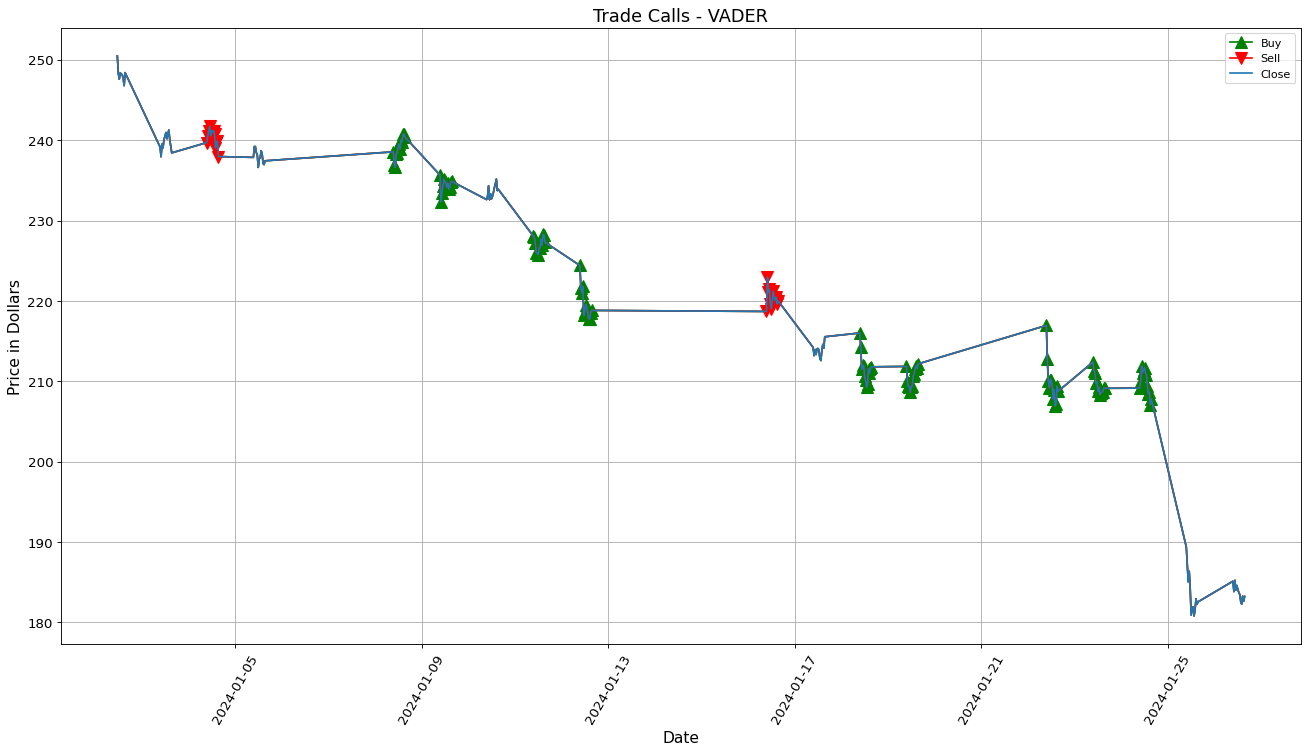

In [ ]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=vader_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=vader_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

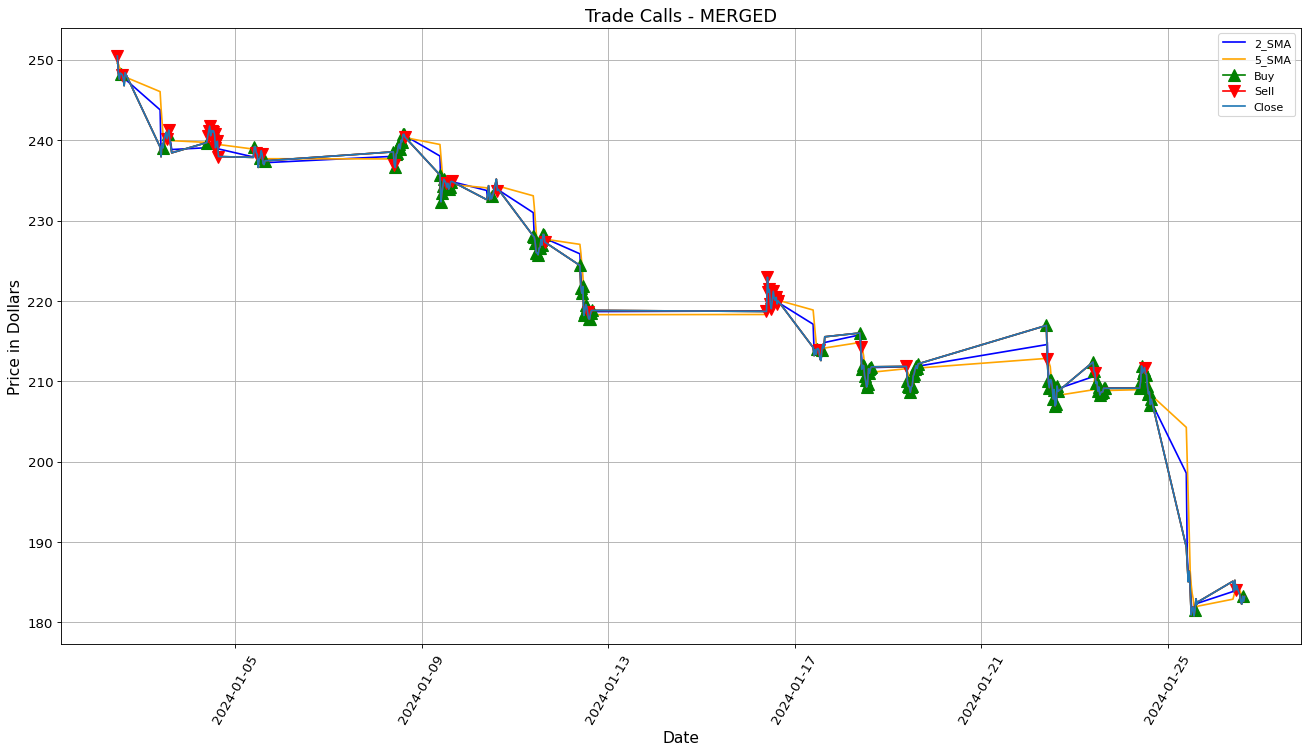

In [ ]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_tsla.index, data_tsla['2_SMA'], color='blue')
plt.plot(data_tsla.index, data_tsla['5_SMA'], color='orange')
plt.plot(data_tsla.index, data_tsla['Close'],'-^', markevery=final_buy, ms=10, color='green')
plt.plot(data_tsla.index, data_tsla['Close'],'-v', markevery=final_sell, ms=10, color='red')
plt.plot(data_tsla.index, data_tsla['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 

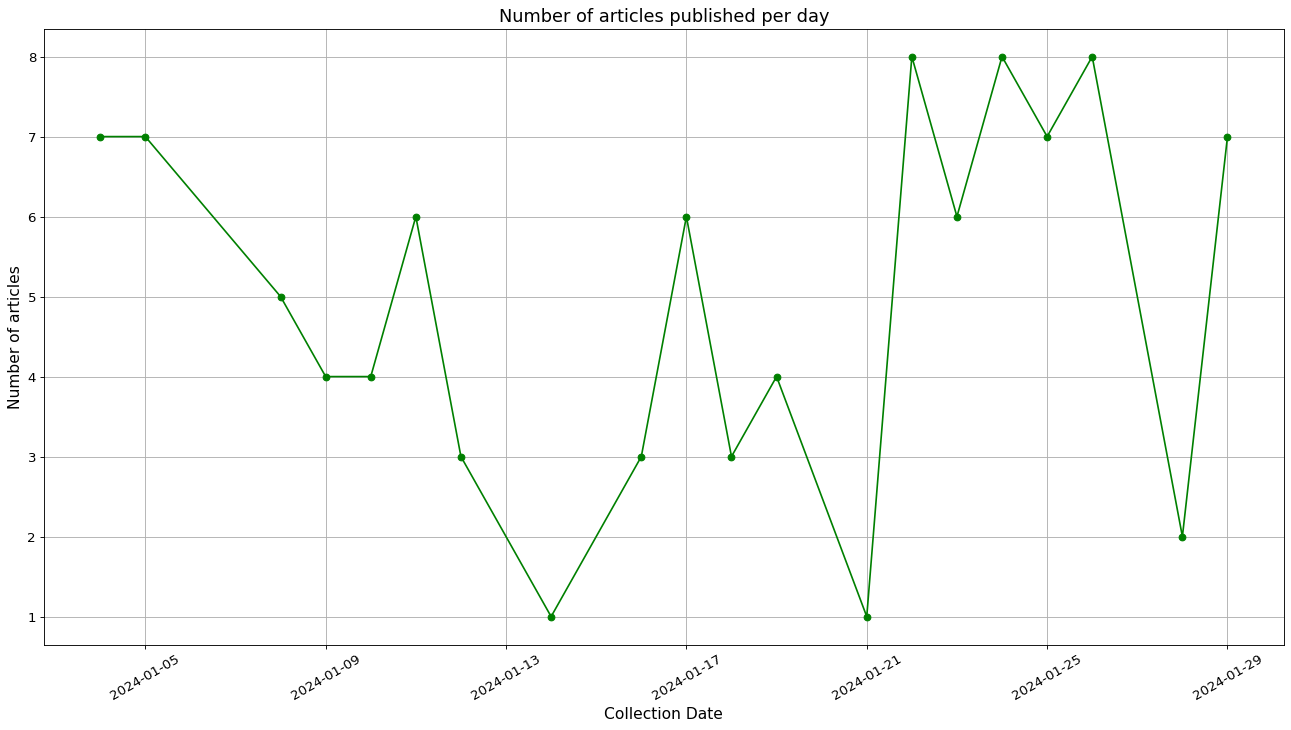

In [ ]:
import matplotlib.pyplot as plt

# Đảm bảo rằng cột 'date' là kiểu dữ liệu datetime
news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'])
news_df['date'] = news_df['publishedAt'].dt.date

# Tính toán số lượng content mỗi ngày
content_count = news_df.groupby('date').size()

# Vẽ biểu đồ
plt.figure(figsize=(20,10), dpi=80)
content_count.plot(kind='line', marker='o', color='green')
plt.title('Number of articles published per day', fontsize = 16)
plt.xlabel('Collection Date', fontsize=14)
plt.ylabel('Number of articles',fontsize = 14)
plt.xticks(rotation=30,fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

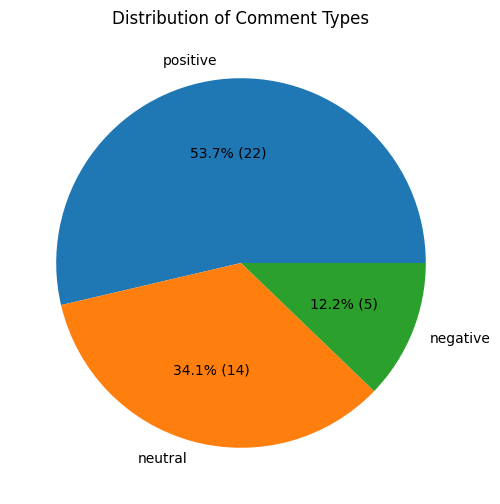

In [ ]:
# Phân loại comment
final_news['comment_type'] = final_news['compound_vader_score'].apply(lambda x: 'positive' if x > 0.33 
                                                                         else ('negative' if x < -0.33 
                                                                        else 'neutral'))

# Đếm số lượng comment cho mỗi loại
comment_counts = final_news['comment_type'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 6))
comment_counts.plot.pie(autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*comment_counts.sum()))
plt.title('Distribution of Comment Types')
plt.ylabel('')
plt.show()

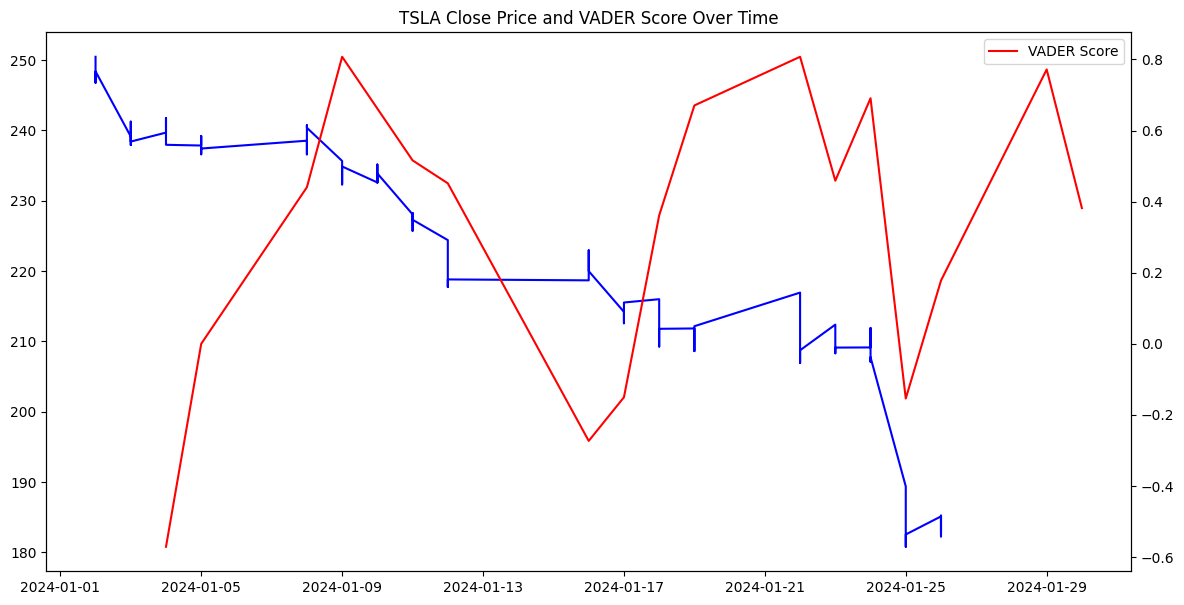

In [ ]:
data_tsla = data_tsla.reset_index()
# Đảm bảo rằng cả hai DataFrame đều được sắp xếp theo 'Date' và đặt 'Date' làm index
data_tsla = data_tsla.sort_values('Datetime').set_index('Datetime')
extreme_scores_df = extreme_scores_df.sort_values('Date').set_index('Date')



# Vẽ biểu đồ đường cho giá đóng cửa
plt.figure(figsize=(14, 7))
plt.plot(data_tsla['Close'], label='TSLA Close Price', color='blue')

# Vẽ biểu đồ đường cho điểm FinVADER
# Chúng ta sử dụng plt.twinx() để vẽ biểu đồ trên cùng một hình nhưng với hai trục y khác nhau
plt.twinx()
plt.plot(extreme_scores_df['final_scores'], label='VADER Score', color='red')

plt.title('TSLA Close Price and VADER Score Over Time')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# Chuyển đổi 'Datetime' và 'Date' thành cùng một định dạng ngày
data_tsla.index = data_tsla.index.date
extreme_scores_df.index = pd.to_datetime(extreme_scores_df.index).date

# Tính toán hệ số tương quan
correlation = data_tsla['Close'].corr(extreme_scores_df['final_scores'])

print(f"The correlation between the TSLA Close Price and the VADER Score is {correlation}")

AttributeError: 'Index' object has no attribute 'date'